In [96]:
#############################################################################################
# importing the dependencies
#############################################################################################
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [53]:
#############################################################################################
# importing the datasets
#############################################################################################

q2 = pd.read_csv("data/q2_knn.csv")
q3 = pd.read_csv("data/q3_knn.csv")
q4 = pd.read_csv("data/q4_knn.csv")
q5 = pd.read_csv("data/q5_knn.csv")
q6 = pd.read_csv("data/q6_knn.csv")
q8 = pd.read_csv("data/q8_knn.csv")

q2['date_time'] = pd.to_datetime(q2['date_time'])
q3['date_time'] = pd.to_datetime(q3['date_time'])
q4['date_time'] = pd.to_datetime(q4['date_time'])
q5['date_time'] = pd.to_datetime(q5['date_time'])
q6['date_time'] = pd.to_datetime(q6['date_time'])
q8['date_time'] = pd.to_datetime(q8['date_time'])

q2['dataset'] = 'S0014'
q3['dataset'] = 'S0015'
q4['dataset'] = 'S0016'
q5['dataset'] = 'S0022'
q6['dataset'] = 'S0024'

q2_rn = pd.read_csv("data/rain_q2.csv")
q3_rn = pd.read_csv("data/rain_q3.csv")
q4_rn = pd.read_csv("data/rain_q4.csv")
q5_rn = pd.read_csv("data/rain_q5.csv")
q6_rn = pd.read_csv("data/rain_q6.csv")

q2_rn['time'] = pd.to_datetime(q2_rn['time'])
q3_rn['time'] = pd.to_datetime(q3_rn['time'])
q4_rn['time'] = pd.to_datetime(q4_rn['time'])
q5_rn['time'] = pd.to_datetime(q5_rn['time'])
q6_rn['time'] = pd.to_datetime(q6_rn['time'])

f3 = pd.read_csv("data/f3_knn.csv")
f4 = pd.read_csv("data/f4_knn.csv")
f5 = pd.read_csv("data/f5_knn.csv")

f3['Time'] = pd.to_datetime(f3['Time'])
f4['Time'] = pd.to_datetime(f4['Time'])
f5['Time'] = pd.to_datetime(f5['Time'])

In [146]:
#############################################################################################
# filtering values based on event date
#############################################################################################

th = 0.75
#18-06-2020
e_date = ["2020-07-02"]
e_date = pd.to_datetime(e_date)

evq2 = q2[q2['date_time'].dt.date.isin(e_date.date)]
evq3 = q3[q3['date_time'].dt.date.isin(e_date.date)]
evq4 = q4[q4['date_time'].dt.date.isin(e_date.date)]
evq5 = q5[q5['date_time'].dt.date.isin(e_date.date)]
evq6 = q6[q6['date_time'].dt.date.isin(e_date.date)]
evq8 = q8[q8['date_time'].dt.date.isin(e_date.date)]

evq2.loc[:, 'date_time'] = pd.to_datetime(evq2['date_time'])
evq3.loc[:, 'date_time'] = pd.to_datetime(evq3['date_time'])
evq4.loc[:, 'date_time'] = pd.to_datetime(evq4['date_time'])
evq5.loc[:, 'date_time'] = pd.to_datetime(evq5['date_time'])
evq6.loc[:, 'date_time'] = pd.to_datetime(evq6['date_time'])
evq8.loc[:, 'date_time'] = pd.to_datetime(evq8['date_time'])

In [55]:
combined_data = pd.concat([ evq2, evq3, evq4, evq5, evq6], ignore_index=True)

freq_quality = (combined_data
                .query('NH4 > @th')  # Filter rows where NH4 is greater than the threshold
                .groupby('dataset')  # Group by the 'dataset' column
                .size()              # Count the number of occurrences
                .reset_index(name='n')  # Convert the result to a DataFrame with a column 'n'
                .assign(n=lambda x: round(x['n'] / (288*len(e_date)),2))
               )

# Print the resulting DataFrame
print(freq_quality)

  dataset     n
0   S0014  0.23
1   S0015  0.25
2   S0016  1.00
3   S0022  0.18
4   S0024  0.62


In [105]:
def plot_top_peaks(evq5, title, i, num_peaks=3):
    """
    Plots NH4 concentration over time and highlights the top peaks.

    Parameters:
    - evq5: DataFrame containing 'date_time' and 'NH4' columns.
    - num_peaks: Number of top peaks to highlight (default is 3).

    Returns:
    - None (plots the graph).
    """
    # Ensure 'date_time' column is in datetime format
    evq5.loc[:, 'date_time'] = pd.to_datetime(evq5['date_time'])

    # Find all peaks in the 'NH4' column
    peaks, _ = find_peaks(evq5['NH4'])

    # Sort the peaks by the NH4 values to find the top peaks
    sorted_peaks = peaks[np.argsort(evq5['NH4'].iloc[peaks])][::-1]  # Sort descending
    top_peaks = sorted_peaks[:num_peaks]  # Select the top peaks

    # Get the corresponding 'date_time' and 'NH4' values for the top peaks
    top_dates = evq5['date_time'].iloc[top_peaks]
    top_values = evq5['NH4'].iloc[top_peaks]

    # Print the results
    print(f"Top {num_peaks} peaks found at the following date_time values:")
    for date, value in zip(top_dates, top_values):
        print(f"Date: {date}, NH4 Value: {value}")

    # Plotting the data and marking the top peaks
    plt.figure(figsize=(12, 7))
    plt.plot(evq5['date_time'], evq5['NH4'], label='TAN Concentration', color='blue', linewidth=2)
    plt.plot(top_dates, top_values, 'x', color='red', markersize=13, label='Peaks')  # Larger crosses

    # Add a horizontal line at y=0.75 and include it in the legend
    plt.axhline(y=0.75, color='green', linestyle='--', linewidth=2, label='Threshold')

    # Annotate top peaks with time in 24hr format
    texts = [plt.text(date, value, date.strftime('%H:%M:%S'), 
                      fontsize=22, ha='center', va='bottom', color='red') 
             for date, value in zip(top_dates, top_values)]
    
    # Adjust text to avoid overlap
    adjust_text(texts, 
                arrowprops=dict(arrowstyle="->", color='red', lw=0.5),
                force_points=0.2, 
                force_text=0.2, 
                expand_text=(1.3, 1.3))

    # Modify x-axis to only show time
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    plt.title(title, fontsize=26)
    plt.xlabel('Time', fontsize=24)
    plt.ylabel('TAN Concentration (mg/l)', fontsize=24)
    plt.legend(fontsize=22)  # Larger legend
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.xticks(fontsize=23)  # Larger x-axis tick labels
    plt.yticks(fontsize=23)  # Larger y-axis tick labels
    plt.savefig(f"plots/{title}_{i}")
    plt.show()

Top 2 peaks found at the following date_time values:
Date: 2020-07-02 01:30:00, NH4 Value: 0.8299999999999998
Date: 2020-07-02 06:10:00, NH4 Value: 0.5


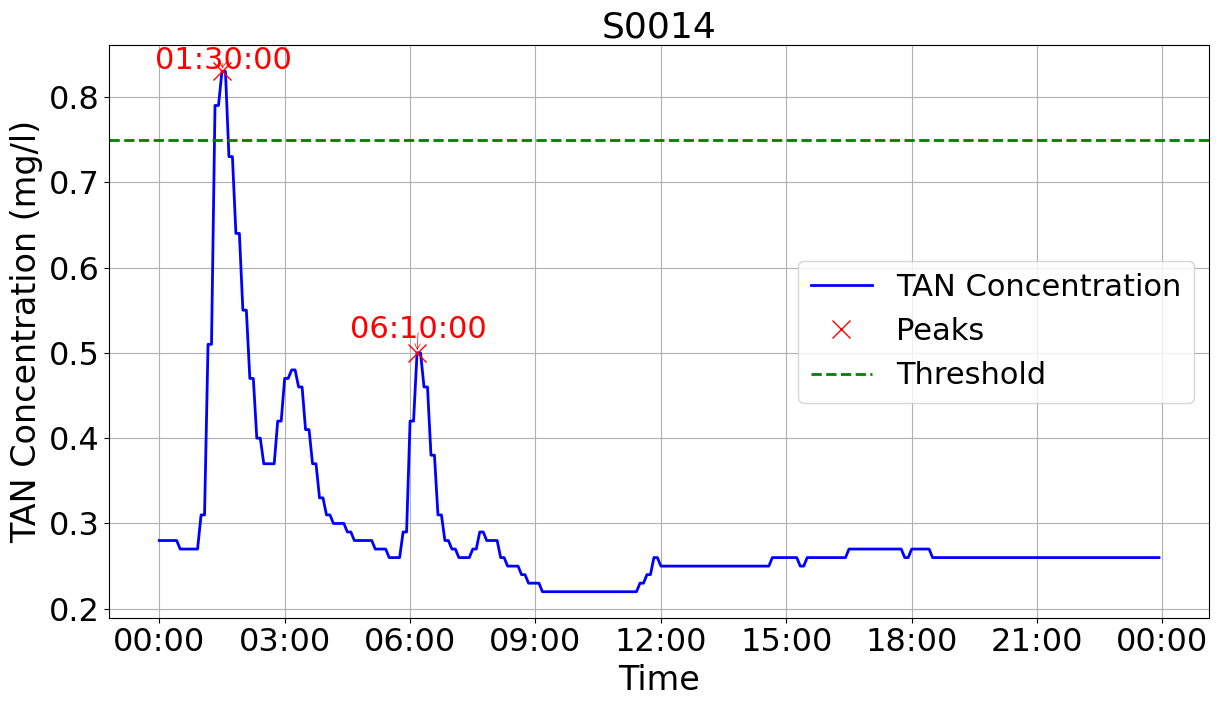

In [137]:
plot_top_peaks(evq2, "S0014","4",num_peaks=2)

Top 2 peaks found at the following date_time values:
Date: 2020-07-02 01:35:00, NH4 Value: 0.9
Date: 2020-07-02 06:20:00, NH4 Value: 0.61


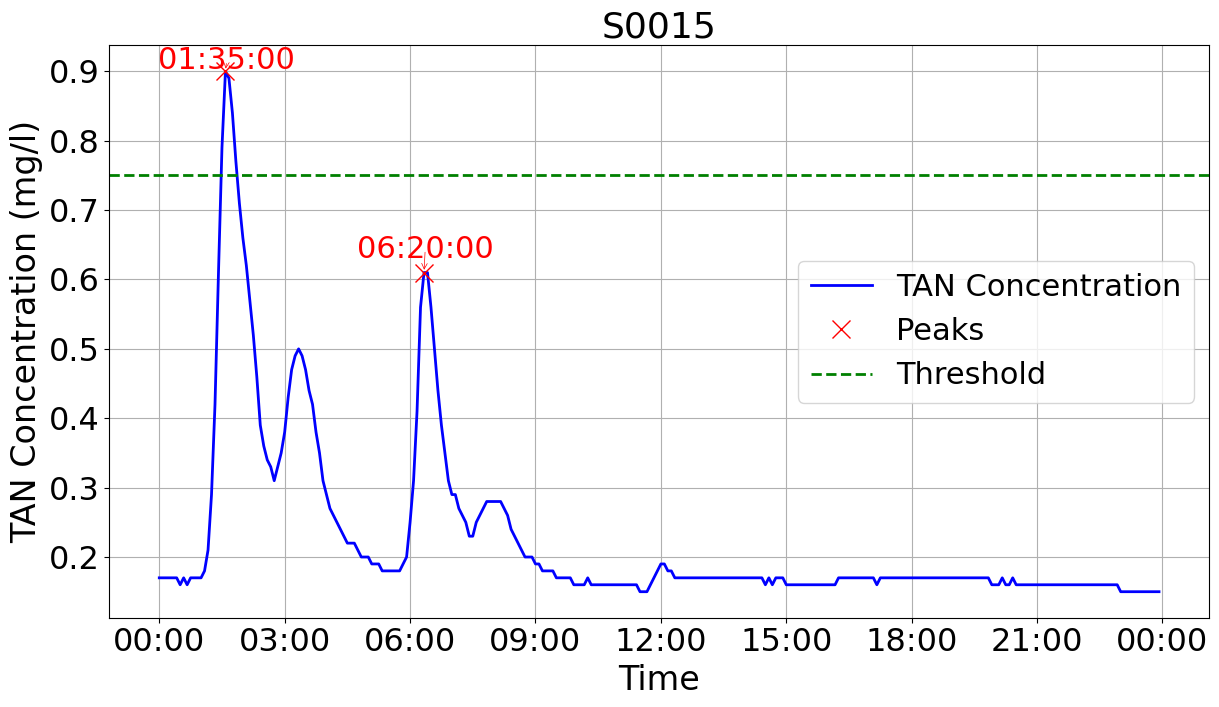

In [138]:
plot_top_peaks(evq3, "S0015","4",num_peaks=2)

Top 2 peaks found at the following date_time values:
Date: 2020-07-02 02:50:00, NH4 Value: 0.82
Date: 2020-07-02 06:30:00, NH4 Value: 0.64


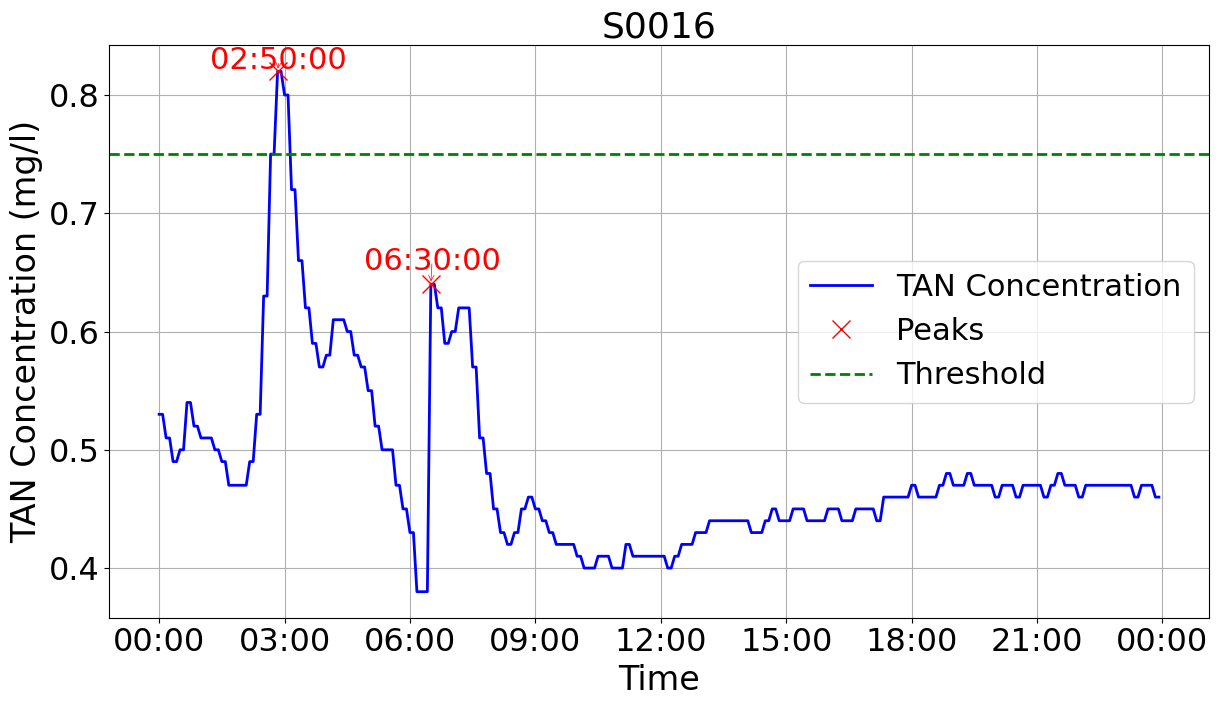

In [139]:
plot_top_peaks(evq4, "S0016","4",num_peaks=2)

Top 2 peaks found at the following date_time values:
Date: 2020-07-02 04:40:00, NH4 Value: 0.9
Date: 2020-07-02 08:05:00, NH4 Value: 0.72


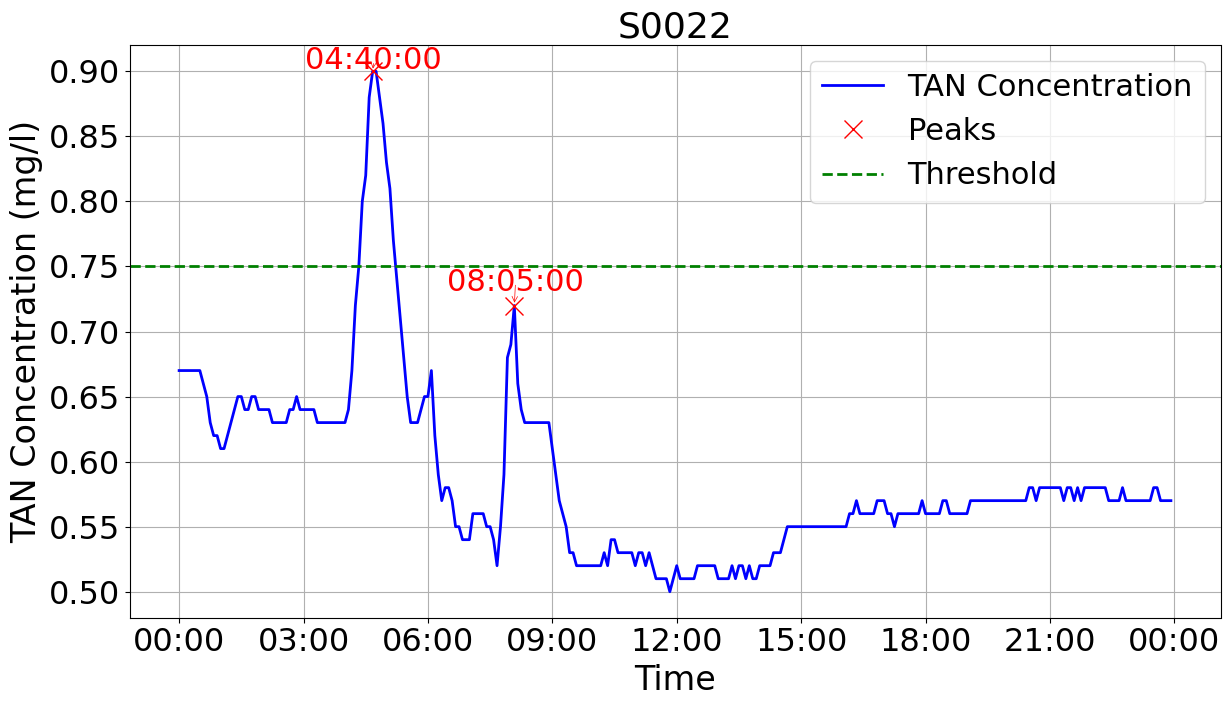

In [140]:
plot_top_peaks(evq5, "S0022","4",num_peaks=2)

Top 1 peaks found at the following date_time values:
Date: 2020-07-02 06:25:00, NH4 Value: 0.9


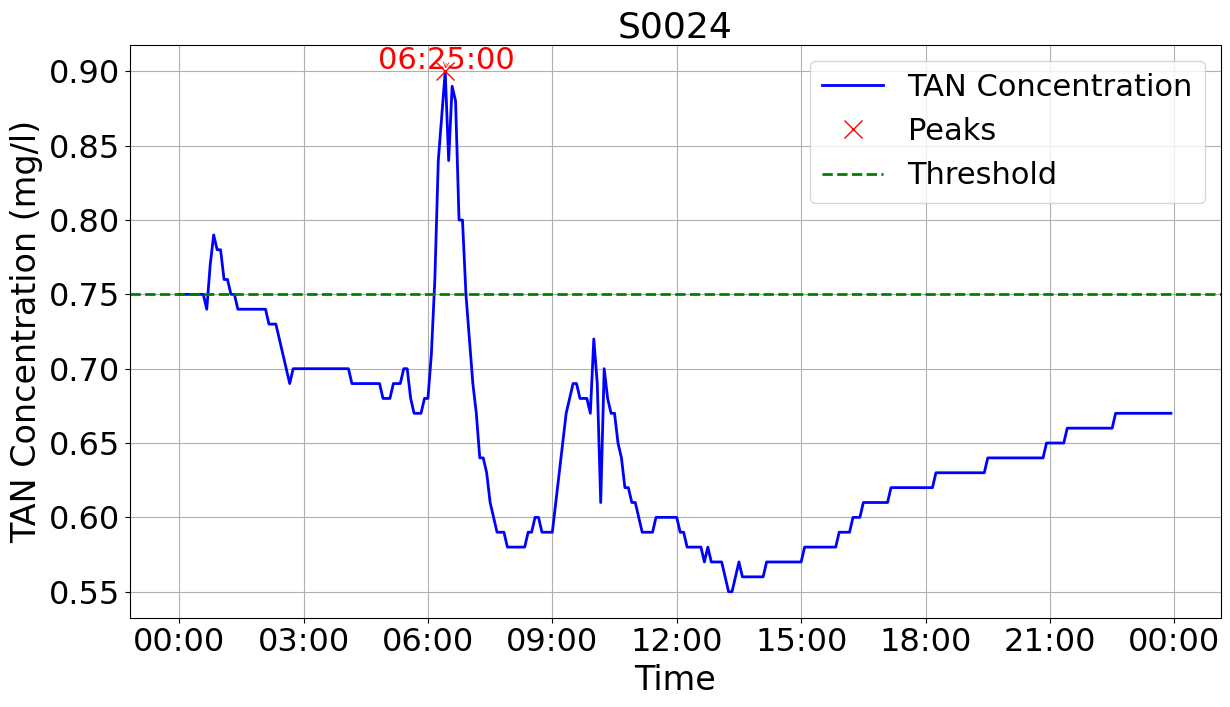

In [141]:
plot_top_peaks(evq6, "S0024","4",num_peaks=1)

In [88]:
def get_peak_date_time(df, peak_no):
    """
    Finds peaks in the NH4 concentration data and returns the date_time of the specified peak.

    Parameters:
    - df: DataFrame containing 'date_time' and 'NH4' columns.
    - peak_no: Number of the peak to retrieve (1 for first peak, 2 for second, etc.).

    Returns:
    - date_time: The date_time of the specified peak if it exists; otherwise, None.
    """
    # Ensure 'date_time' column is in datetime format
    df.loc[:, 'date_time'] = pd.to_datetime(df['date_time'])

    # Find all peaks in the 'NH4' column
    peaks, _ = find_peaks(df['NH4'])

    # Sort the peaks by the NH4 values to find the top peaks
    sorted_peaks = peaks[np.argsort(df['NH4'].iloc[peaks])][::-1]  # Sort descending

    # Check if the specified peak number is valid
    if 1 <= peak_no <= len(sorted_peaks):
        peak_index = peak_no - 1  # Convert peak number to zero-based index
        selected_peak = sorted_peaks[peak_index]
        date_time_of_peak = df['date_time'].iloc[selected_peak]
        return date_time_of_peak
    else:
        print(f"Invalid peak number {peak_no}. It should be between 1 and {len(sorted_peaks)}.")
        return None

In [147]:
p2 = get_peak_date_time(evq2,1)
p3 = get_peak_date_time(evq3,1)
p4 = get_peak_date_time(evq4,1)
p5 = get_peak_date_time(evq5,1)
p6 = get_peak_date_time(evq6,1)

In [143]:
def calculate_transit_times(peak_times):
    """
    Calculates the transit times between given peak times and updates the 'lengths' DataFrame
    with these transit times and velocities.

    Parameters:
    - peak_times: List of datetime objects representing the peak times.

    Returns:
    - updated_lengths: DataFrame with added transit times and velocity.
    """
    # Load the lengths DataFrame
    lengths = pd.read_csv("data/lengths.csv")

    # Calculate transit times between consecutive peaks
    transit_times = []
    for i in range(len(peak_times) - 1):
        if peak_times[i] is not None and peak_times[i + 1] is not None:
            # Calculate time difference in seconds
            transit_time = (peak_times[i + 1] - peak_times[i]).total_seconds()
            transit_times.append(int(transit_time))
        else:
            transit_times.append(None)  # Handle cases where peak time is None

    # Update the 'lengths' DataFrame with transit times
    lengths['transit_time'] = transit_times

    # Add 'Transit time (mins)' column
    lengths['Transit time (mins)'] = lengths['transit_time'] / 60

    # Ensure 'Length (in m)' column exists in lengths DataFrame before calculating 'Velocity'
    if 'Length (in m)' not in lengths.columns:
        raise ValueError("The 'lengths' DataFrame must contain a 'Length (in m)' column.")

    # Add 'Velocity' column
    lengths['Velocity'] = round(lengths['Length (in m)'] / lengths['transit_time'].replace(0, pd.NA), 2)  # Avoid division by zero

    # Drop 'Length (in m)' column after calculating velocity
    #lengths.drop(columns=['Length (in m)'], inplace=True)

    return lengths

In [148]:
dynamics = calculate_transit_times([p2,p3,p4,p5,p6])
dynamics = dynamics.round(2)
print(dynamics)
dynamics.to_csv("output/dynamics.csv", index = False)

              ID  Length (in m)  transit_time  Transit time (mins)  Velocity
0  S0014 - S0015          93.45           300                  5.0      0.31
1  S0015 - S0016        1550.04          4500                 75.0      0.34
2  S0016 - S0022        2975.72          6600                110.0      0.45
3  S0022 - S0024        1563.08          6300                105.0      0.25


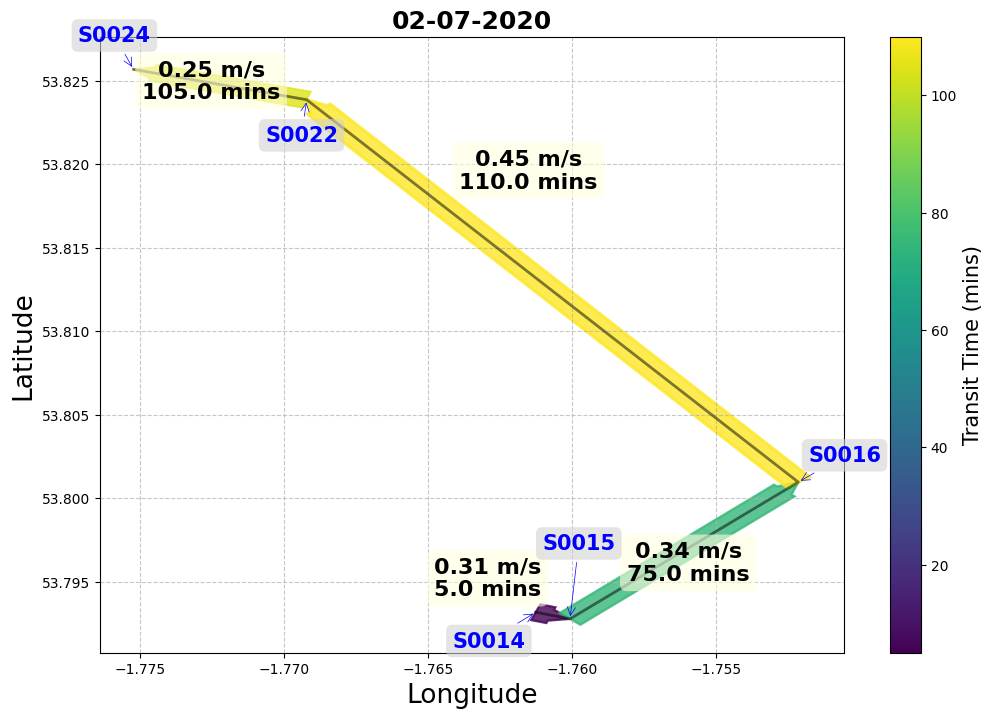

In [145]:
latitudes = [53.793175, 53.792774,53.800961, 53.823853, 53.825672]
longitudes = [-1.761259,-1.760066, -1.752136, -1.769213, -1.775231]

transit_times = dynamics["Transit time (mins)"]
velocities = dynamics["Velocity"]
site_labels = ['S0014', 'S0015', 'S0016', 'S0022', 'S0024'] 
title = "02-07-2020"
norm = mcolors.Normalize(vmin=min(transit_times), vmax=max(transit_times))
cmap = cm.viridis  # You can choose any colormap here

fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the river as a line
ax.plot(longitudes, latitudes, 'k-', lw=2, alpha=0.5)

# Adding arrows to represent movement
for i in range(len(longitudes) - 1):
    velocity = velocities[i]
    transit_time = transit_times[i]
    
    # Scale the thickness more for visibility
    line_thickness = 5 * velocity  # Increased scaling factor
    
    # Get color from colormap based on normalized transit time
    color = cmap(norm(transit_time))
    
    # Add arrows with increased offset from the line
    ax.arrow(
        longitudes[i], latitudes[i],
        longitudes[i + 1] - longitudes[i], latitudes[i + 1] - latitudes[i],
        head_width=0.0007, head_length=0.0007, fc=color, ec=color,
        linewidth=line_thickness, length_includes_head=True, alpha=0.8
    )
    
# Manually adjust position for velocity and transit time labels
ax.annotate(
    f'{velocities[3]} m/s\n{transit_times[3]} mins',
    xy=(-1.7735, 53.8245),  # Adjusted position
    xytext=(20, -10),
    textcoords='offset points',
    fontsize=16, fontweight='bold', color='black',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightyellow', alpha=0.6),
    ha='center', va='bottom'
)

ax.annotate(
    f'{velocities[2]} m/s\n{transit_times[2]} mins',
    xy=(-1.762, 53.8175),  # Adjusted closer to the line
    xytext=(10, 10),  # Adjusted closer to the line
    textcoords='offset points',
    fontsize=16, fontweight='bold', color='black',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightyellow', alpha=0.6),
    ha='center', va='bottom'
)

ax.annotate(
    f'{velocities[1]} m/s\n{transit_times[1]} mins',
    xy=(-1.755, 53.7965),  # Adjusted position
    xytext=(-20, -20),
    textcoords='offset points',
    fontsize=16, fontweight='bold', color='black',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightyellow', alpha=0.6),
    ha='center', va='bottom'
)

ax.annotate(
    f'{velocities[0]} m/s\n{transit_times[0]} mins',
    xy=(-1.761, 53.7935),  # Adjusted closer to the line
    xytext=(-40, 5),  # Adjusted closer to the line
    textcoords='offset points',
    fontsize=16, fontweight='bold', color='black',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightyellow', alpha=0.6),
    ha='center', va='bottom'
)

# Adjust site label positions manually with precise coordinates
ax.annotate(
    'S0024',
    xy=(-1.775231, 53.825672),  # Actual position
    xytext=(-40, 20),  # Adjusted to avoid overlap
    textcoords='offset points',
    fontsize=15, fontweight='bold', color='blue',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightgray', alpha=0.6),
    arrowprops=dict(arrowstyle="->", color='blue', lw=0.5)
)

ax.annotate(
    'S0022',
    xy=(-1.769213, 53.823853),  # Actual position
    xytext=(-30, -30),  # Adjusted to avoid overlap
    textcoords='offset points',
    fontsize=15, fontweight='bold', color='blue',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightgray', alpha=0.6),
    arrowprops=dict(arrowstyle="->", color='blue', lw=0.5)
)

ax.annotate(
    'S0016',
    xy=(-1.752136, 53.800961),  # Actual position
    xytext=(7, 15),  # Brought closer inside the plot
    textcoords='offset points',
    fontsize=15, fontweight='bold', color='blue',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightgray', alpha=0.6),
    arrowprops=dict(arrowstyle="->", color='blue', lw=0.5)
)

ax.annotate(
    'S0015',
    xy=(-1.760066, 53.792774),  # Actual position
    xytext=(-20, 50),  # Adjusted to avoid overlap
    textcoords='offset points',
    fontsize=15, fontweight='bold', color='blue',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightgray', alpha=0.6),
    arrowprops=dict(arrowstyle="->", color='blue', lw=0.5)
)

ax.annotate(
    'S0014',
    xy=(-1.761259, 53.793175),  # Actual position
    xytext=(-60, -25),  # Adjusted to avoid overlap
    textcoords='offset points',
    fontsize=15, fontweight='bold', color='blue',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='lightgray', alpha=0.6),
    arrowprops=dict(arrowstyle="->", color='blue', lw=0.5)
)

# Add colorbar for transit times
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Transit Time (mins)', fontsize=15)

# Adjust labels, title, and grid
ax.set_title(title, fontsize=18, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=19)
ax.set_ylabel('Latitude', fontsize=19)
ax.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"plots/{title}.png")
plt.show()

In [414]:
def plot_transit_data(df,title):
    # Calculate cumulative length and time starting from zero
    df['Cumulative Length (m)'] = df['Length (in m)'].cumsum()
    df['Cumulative Time (mins)'] = df['transit_time'].cumsum()

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16, 12))

    # Include the reference point (S0014) at origin
    times = [0] + df['Cumulative Time (mins)'].tolist()
    lengths = [0] + df['Cumulative Length (m)'].tolist()
    
    # Extract the site labels (individual sites)
    sites = df['ID'].str.split(' - ').tolist()
    sites = [sites[0][0]] + [site[1] for site in sites]
    
    # Plot the cumulative length against cumulative time
    line, = ax1.plot(times, lengths, 'o-', color='blue', label='Site')

    # Label each site point with the individual site
    texts = []
    for i, (time, length, site) in enumerate(zip(times, lengths, sites)):
        text = ax1.text(time, length, site, fontsize=21, ha='center', va='bottom', color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), zorder=5)
        texts.append(text)

    # Adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, arrowprops=dict(arrowstyle="-", color='grey', lw=0.7))

    # Set axis labels with larger fonts
    ax1.set_xlabel('Cumulative Transit Time (sec)', fontsize=23)
    ax1.set_ylabel('Cumulative Length (m)', fontsize=23)
    
    # Increase the font size of the axis ticks
    ax1.tick_params(axis='both', which='major', labelsize=21)

    # Add a secondary y-axis for the velocity
    ax2 = ax1.twinx()
    
    # Calculate bar positions and widths correctly
    bar_width = 0.5 * np.mean(np.diff(df['Cumulative Time (mins)']))  # Adjust this to control the bar width
    bar_positions = df['Cumulative Time (mins)'].tolist()
    bar_positions = np.array(bar_positions) - np.diff([0] + df['Cumulative Time (mins)'].tolist()) / 2  # Center the bars

    # Ensure the bar heights and widths match the number of bars
    bars = ax2.bar(bar_positions, 
                   df['Velocity'] * 0.5,  # Scale down bar heights to make them thinner
                   width=bar_width,
                   alpha=0.2, color='green', label='Velocity')  # Light color for the bars

    ax2.set_ylabel('Velocity (m/s)', fontsize=21)
    
    # Increase the font size of the axis ticks for the secondary y-axis
    ax2.tick_params(axis='both', which='major', labelsize=21)

    # Combine legends for both axes and position them in the top-left corner
    #ax1.legend(loc='upper left', fontsize=19)
    ax2.legend(loc='upper left', fontsize=21)

    # Set the title with a larger font size
    plt.title(title, fontsize=24)
    plt.savefig(f"plots/{title}")
    # Display the plot
    plt.show()

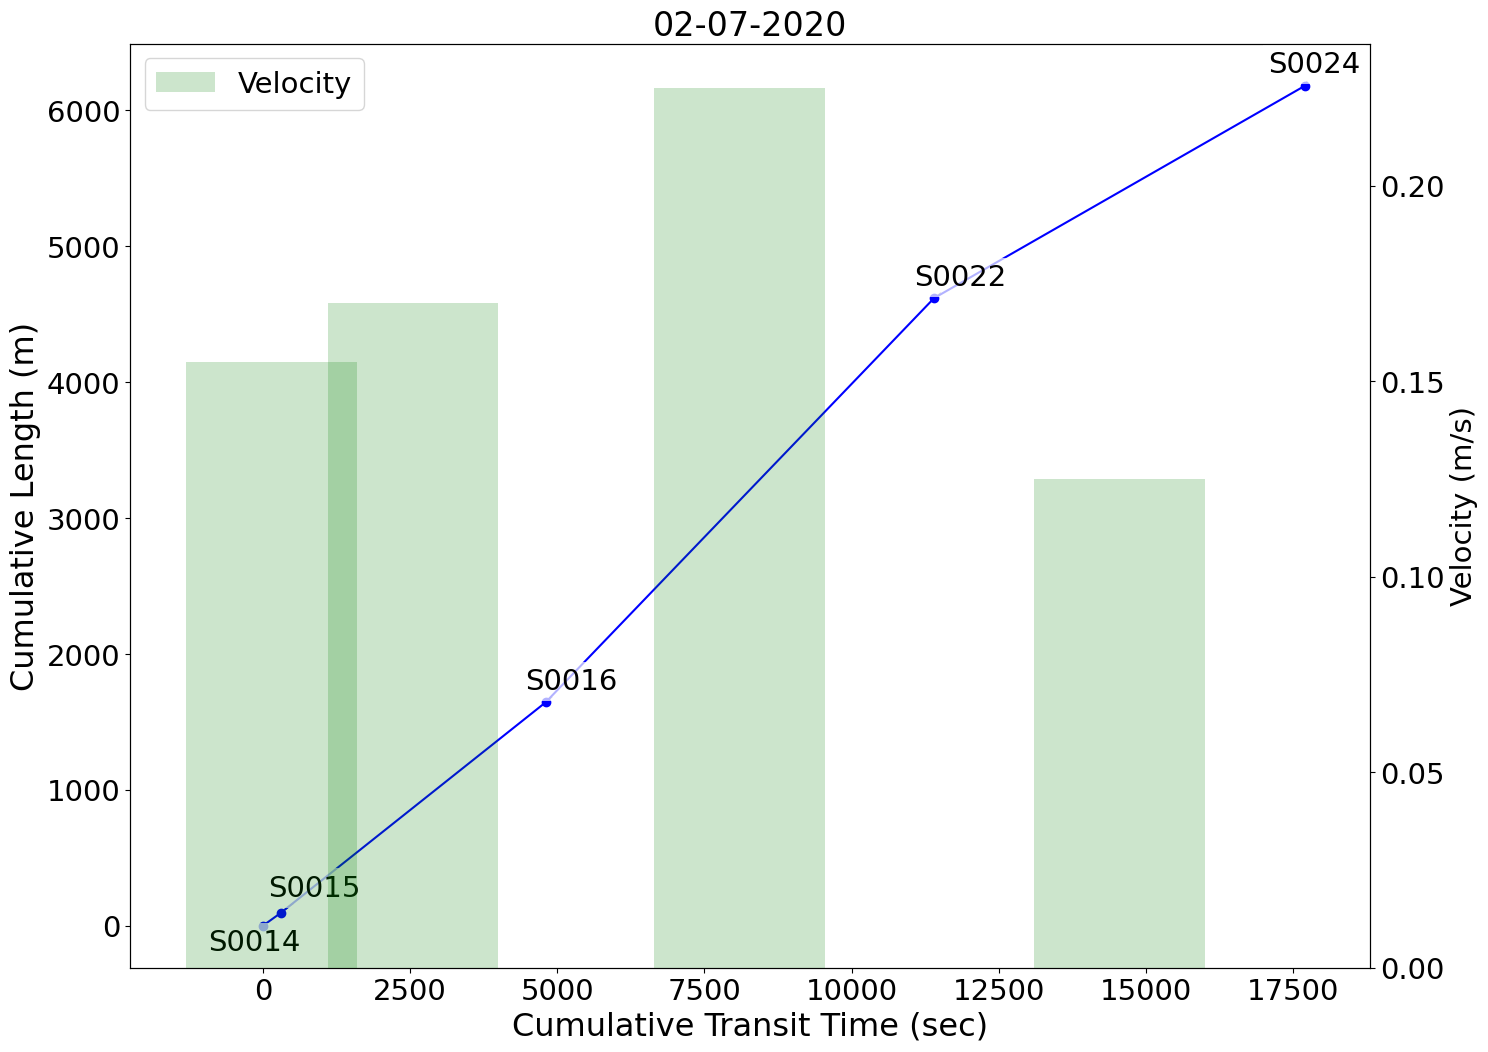

In [436]:
plot_transit_data(dynamics, "29-04-2020")

In [150]:
def calculate_values_by_date(dt):
    """Calculate and return values for rainfall, flow volume, and NH3 concentration for a given date.
    
    Parameters:
    - dt: str, the date for which to calculate values, in 'YYYY-MM-DD' format.
    - q2_rn, q3_rn, q4_rn, q5_rn, q6_rn: DataFrames containing 'time' and 'rainfall' columns.
    - f3, f4, f5: DataFrames containing 'Time' and 'f_volume' columns.
    - q2, q3, q4, q5, q6: DataFrames containing 'date_time' and 'NH3' columns.
    
    Returns:
    - DataFrame with calculated values.
    """
    
    # Convert date string to datetime object for comparison
    date = pd.to_datetime(dt).date()
    
    # Function to filter DataFrame by date and get the mean of a specified column
    def get_mean_for_date(df, date_column, value_column):
        df['date'] = pd.to_datetime(df[date_column]).dt.date
        filtered_df = df[df['date'] == date]
        return filtered_df[value_column].mean() if not filtered_df.empty else None
    
    # Rainfall calculations
    rainfall_values = [
        get_mean_for_date(q2_rn, 'time', 'rainfall'),
        get_mean_for_date(q3_rn, 'time', 'rainfall'),
        get_mean_for_date(q4_rn, 'time', 'rainfall'),
        get_mean_for_date(q5_rn, 'time', 'rainfall'),
        get_mean_for_date(q6_rn, 'time', 'rainfall')
    ]
    
    # Flow volume calculations
    flow_values = [
        get_mean_for_date(f3, 'Time', 'f_volume'),
        get_mean_for_date(f3, 'Time', 'f_volume'),
        get_mean_for_date(f4, 'Time', 'f_volume'),
        get_mean_for_date(f5, 'Time', 'f_volume'),
        get_mean_for_date(f5, 'Time', 'f_volume')
    ]
    
    # TAN (NH3) calculations
    tan_values = [
        get_mean_for_date(q2, 'date_time', 'NH4'),
        get_mean_for_date(q3, 'date_time', 'NH4'),
        get_mean_for_date(q4, 'date_time', 'NH4'),
        get_mean_for_date(q5, 'date_time', 'NH4'),
        get_mean_for_date(q6, 'date_time', 'NH4')
    ]
    
    # Ensure lists are of equal length for consistency
    if len(rainfall_values) != len(tan_values):
        raise ValueError("Mismatch in the number of sites for rainfall and TAN values.")
    
    # Create DataFrame with results
    data = {
        'Sites': ['S0014', 'S0015', 'S0016', 'S0022', 'S0024'],
        'Average rainfall (mm)': rainfall_values,
        'Average flow (m3/s)': flow_values[:len(rainfall_values)],  # Adjust length to match rainfall values
        'Average TAN (mg/l)': tan_values
    }
    
    result_df = pd.DataFrame(data)
    
    return result_df

In [151]:
summary = calculate_values_by_date("2020-07-02")
summary = summary.round(2)
print(summary)
summary.to_csv('output/summary.csv', index=False)

   Sites  Average rainfall (mm)  Average flow (m3/s)  Average TAN (mg/l)
0  S0014                   0.85               744.21                0.29
1  S0015                   0.64               744.21                0.23
2  S0016                   0.82               454.10                0.48
3  S0022                   0.66               502.75                0.59
4  S0024                   0.61               502.75                0.65


In [153]:
def plot_transit_data(df, flow_df, title):
    # Calculate cumulative length and time starting from zero
    df['Cumulative Length (m)'] = df['Length (in m)'].cumsum()
    df['Cumulative Time (mins)'] = df['transit_time'].cumsum()

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16, 12))

    # Include the reference point (S0014) at origin
    times = [0] + df['Cumulative Time (mins)'].tolist()
    lengths = [0] + df['Cumulative Length (m)'].tolist()
    
    # Extract the site labels (individual sites)
    sites = df['ID'].str.split(' - ').tolist()
    sites = [sites[0][0]] + [site[1] for site in sites]

    # Plot the cumulative length against cumulative time
    # Calculate the sizes of the points based on average flow, normalized for better visualization
    normalized_flows = (flow_df['Average flow (m3/s)'] - flow_df['Average flow (m3/s)'].min()) / (flow_df['Average flow (m3/s)'].max() - flow_df['Average flow (m3/s)'].min())

    # Scale the normalized values to a suitable range for plotting
    flow_sizes = normalized_flows * 1000 + 50     
    line, = ax1.plot(times, lengths, '-', color='blue', label='Site')
    scatter = ax1.scatter(times, lengths, s=flow_sizes, color='blue', zorder=5)

    # Label each site point with the individual site
    texts = []
    for i, (time, length, site) in enumerate(zip(times, lengths, sites)):
        text = ax1.text(time, 
                        length + 0.08 * max(lengths),  # Adjust this factor to control the vertical offset
                        site, 
                        fontsize=21, 
                        ha='center', 
                        va='bottom', 
                        color='black', 
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), 
                        zorder=6)
        texts.append(text)
    # Adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, arrowprops=dict(arrowstyle="-", color='grey', lw=0.7))

    # Set axis labels with larger fonts
    ax1.set_xlabel('Cumulative Transit Time (sec)', fontsize=23)
    ax1.set_ylabel('Cumulative Length (m)', fontsize=23)
    
    # Increase the font size of the axis ticks
    ax1.tick_params(axis='both', which='major', labelsize=21)

    # Add a secondary y-axis for the velocity
    ax2 = ax1.twinx()
    
    # Calculate bar positions and widths correctly
    bar_width = 0.5 * np.mean(np.diff(df['Cumulative Time (mins)']))  # Adjust this to control the bar width
    bar_positions = df['Cumulative Time (mins)'].tolist()
    bar_positions = np.array(bar_positions) - np.diff([0] + df['Cumulative Time (mins)'].tolist()) / 2  # Center the bars

    # Ensure the bar heights and widths match the number of bars
    bars = ax2.bar(bar_positions, 
                   df['Velocity'] * 0.5,  # Scale down bar heights to make them thinner
                   width=bar_width,
                   alpha=0.2, color='green', label='Velocity')  # Light color for the bars

    ax2.set_ylabel('Velocity (m/s)', fontsize=21)
    
    # Increase the font size of the axis ticks for the secondary y-axis
    ax2.tick_params(axis='both', which='major', labelsize=21)

    # Combine legends for both axes and position them in the top-left corner
    lines = [line]
    labels = ['Site']
    for bar in bars:
        lines.append(bar)
        labels.append(bar.get_label())

    #ax1.legend(lines, labels, loc='upper left', fontsize=19)
    ax2.legend(loc='upper left', fontsize=21)

    # Set the title with a larger font size
    plt.title(title, fontsize=24)
    plt.savefig(f"plots/{title}")
    # Display the plot
    plt.show()

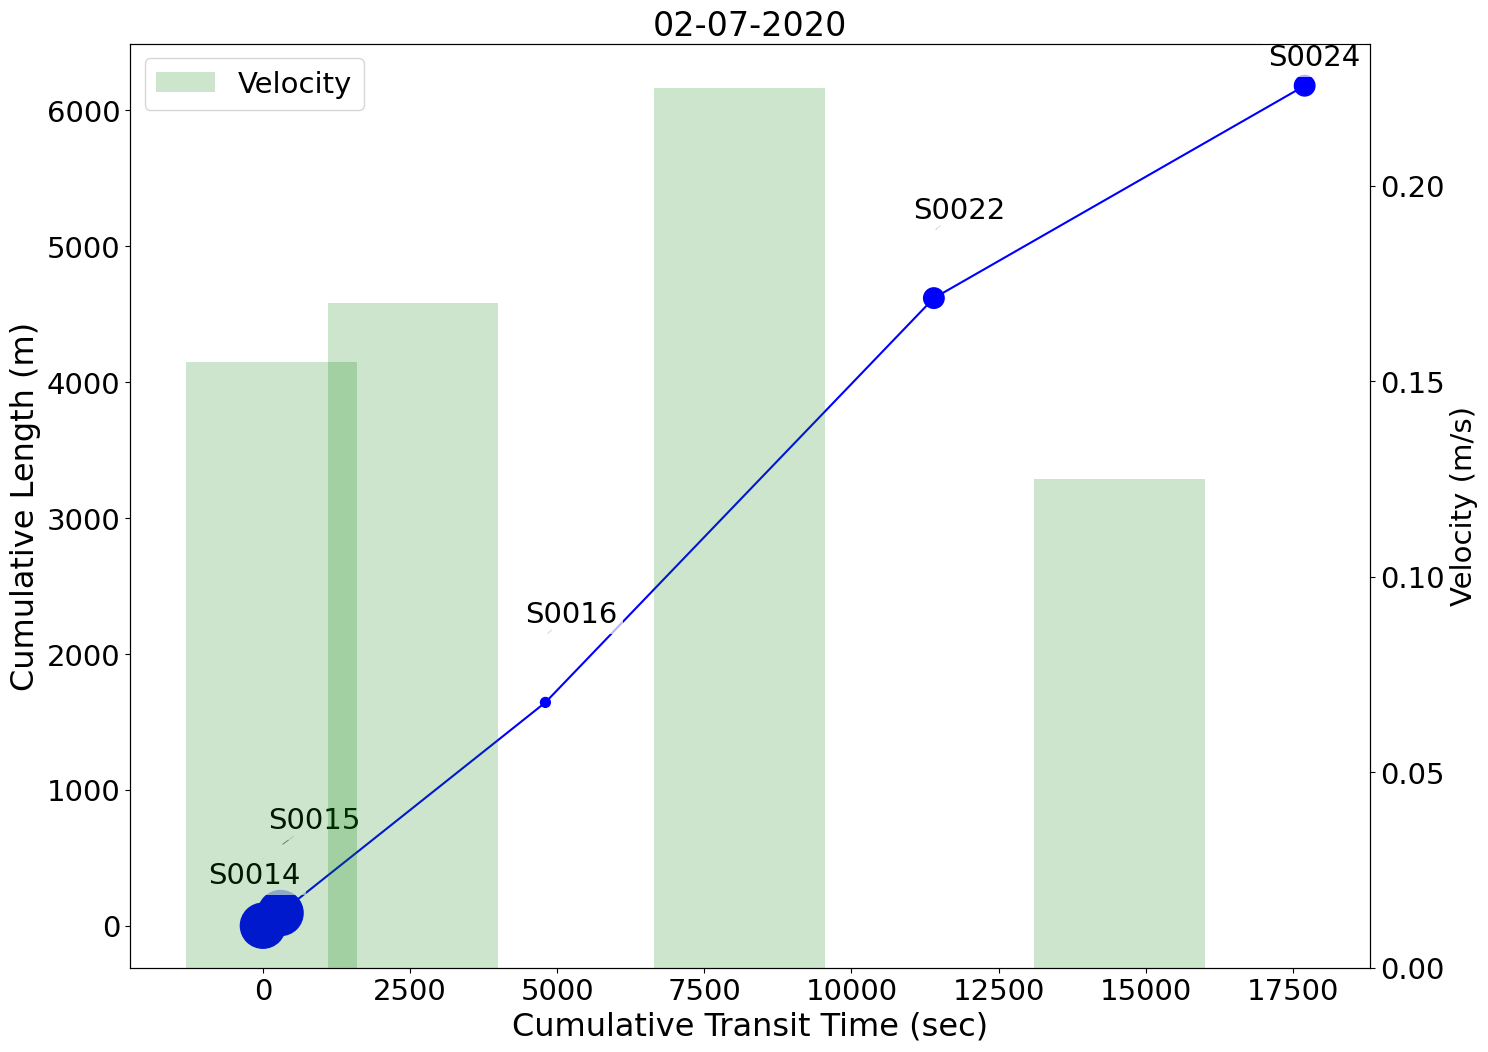

In [154]:
plot_transit_data(dynamics,summary,"02-07-2020")

In [ ]:
# Define the data points for each site
data_f0012 = [
    (0, 0.415), (0.1, 0.405), (0.2, 0.32), (0.3, 0.265), (0.4, 0.18),
    (0.5, 0.1), (0.6, 0.055), (0.7, 0.01), (0.8, 0), (0.9, 0),
    (1, 0.03), (1.1, 0.045), (1.2, 0.073), (1.3, 0.111), (1.4, 0.162),
    (1.5, 0.25), (1.6, 0.295), (1.7, 0.42), (1.8, 0.5), (1.9, 1.175),
    (2, 1.715), (0, 1.715), (0, 0.405)
]

data_f0014 = [
    (0, 0.28), (0.2, 0.288), (0.4, 0.248), (0.6, 0.318), (0.8, 0.215),
    (1, 0.147), (1.2, 0.17), (1.4, 0.11), (1.6, 0.118), (1.8, 0.039),
    (2, 0.031), (2.2, 0.03), (2.4, 0.008), (2.6, 0), (2.8, 0.025),
    (3, 0.03), (3.2, 0.02), (3.4, 0.048), (3.6, 0.04), (3.8, 0.04),
    (4, 0.03), (4.2, 0.065), (4.4, 0.395), (4.52, 0.4), (0, 0.4),
    (0, 0.28)
]

data_f0016 = [
    (0, 0.08), (1, 0.07), (1.5, 0.115), (2, 0.19), (2.5, 0.195),
    (3, 0.19), (3.5, 0.13), (4, 0.09), (4.5, 0.11), (5, 0.085),
    (5.5, 0.05), (6, 0.09), (6.5, 0.02), (7, 0), (7.5, 0.02),
    (8, 0.07), (8.285, 0.115), (8.285, 3.295), (0, 3.295), (0, 0.08)
]

data_f0022 = [
    (0, 1.188325), (0, 0.655), (0.2, 0.635), (0.4, 0.605), (0.6, 0.5),
    (0.8, 0.415), (1, 0.335), (1.2, 0.275), (1.4, 0.235), (1.6, 0.195),
    (1.8, 0.15), (2, 0.09), (2.2, 0.085), (2.4, 0.05), (2.6, 0.045),
    (2.8, 0.02), (3, 0.015), (3.2, 0.005), (3.4, 0), (3.6, 0),
    (3.8, 0.01), (4, 0.04), (4.2, 0.065), (4.4, 0.085), (4.6, 0.13),
    (4.8, 0.175), (5, 0.223325), (5.2, 0.308325), (5.4, 0.348325), (5.6, 0.398325),
    (5.8, 0.513325), (6, 0.578325), (6.2, 0.638325), (6.4, 0.733325), (6.6, 0.803325),
    (6.65, 1.188325), (0, 1.188325)
]

data_f0101 = [
    (0, 1.233), (0.4, 0.089), (0.8, 0.073), (1.2, 0.089), (1.6, 0.124),
    (2, 0.09), (2.4, 0.062), (2.8, 0.027), (3.2, 0), (3.6, 0.002),
    (4, 0.043), (4.4, 1.093), (4.6, 1.233), (4.6, 1.233), (0, 1.233)
]

# Applying the Trapezoidal Rule to calculate the area
def trapezoidal_rule(points):
    area = 0
    n = len(points)
    for i in range(n - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        area += 0.5 * (x2 - x1) * (y1 + y2)
    return abs(area)

# Calculating areas for each site using the trapezoidal rule
area_f0012 = trapezoidal_rule(data_f0012)
area_f0014 = trapezoidal_rule(data_f0014)
area_f0016 = trapezoidal_rule(data_f0016)
area_f0022 = trapezoidal_rule(data_f0022)
area_f0101 = trapezoidal_rule(data_f0101)

print(f"F0012 Area: {area_f0012} square meters")
print(f"F0014 Area: {area_f0014} square meters")
print(f"F0016 Area: {area_f0016} square meters")
print(f"F0022 Area: {area_f0022} square meters")
print(f"F0101 Area: {area_f0101} square meters")


The calculated cross-sectional areas for each site are as follows:
F0010: 4.121 square meters
F0012: 2.884 square meters
F0014: 1.289 square meters
F0016: 26.520 square meters
F0022: 6.126 square meters
F0101: 4.734 square meters